In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
np.warnings.filterwarnings('ignore')

## Wczytywanie i inspekcja danych danych

In [2]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')

### Wybrane cechy

#### Ilościowe:
* w6_q21c_year - w którym roku po raz pierwszy zamieszkali ze sobą
* year_fraction_met - rok poznania z uwzględnieniem miesiąca jako ułamka

### Jakościowe:
* hcm2017q24_btwn_I_neighbor - czy są sąsiadami
* w6_otherdate_all - czy w zeszłym roku poznał(a) kogoś poza partnerem

In [3]:
cat_features = ['hcm2017q24_btwn_I_neighbor', 'w6_otherdate_all']
cont_features = ['w6_q21c_year', 'year_fraction_met']
label = 'S1'

## Transformowanie danych

Podstawowe transformowanie danych:
* zamiana wektora y na wektor 0/1 (0 - małżeństwo, 1 - brak małżeństwa)
* zamiana cech kategorycznych na one hot encoding
* usunięcie niedozwolonych przez XGBooost znaków z nazw cech

Sprawdzamy też, czy po usunięciu NaN nie zostało za mało danych.

In [4]:
data = data[cat_features+cont_features+[label]].dropna()
print("Data left: " + str(len(data)))
X = data[cat_features+cont_features].copy()
y = data[label].cat.codes

Data left: 2566


In [5]:
# Convert continuous features to numerics
for cont_feature in cont_features:
    X[cont_feature] = pd.to_numeric(X[cont_feature])

def convert_to_dummies(X):
    with_dummies = pd.get_dummies(X)
    for character in ['[', ']', '<']:
        with_dummies.columns = with_dummies.columns.str.replace(character, '')
    with_dummies = with_dummies[sorted(with_dummies.columns.to_list())]
    return with_dummies

X = convert_to_dummies(X)

## Trening

Do treningu używam klasyfikatora XGB z domyślnymi parametrami.

In [6]:
# XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## Wykres diagnostyczny

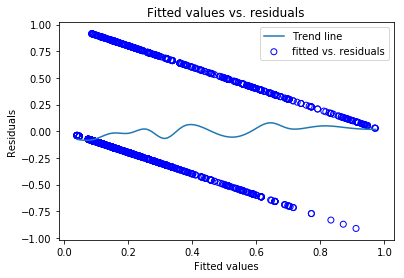

In [38]:
from pygam import LinearGAM

def get_trend_line(xs, ys):
    gam = LinearGAM().fit(xs, ys)
    lin = np.linspace(min(xs), max(xs), num=100)
    return (lin, 
            gam.partial_dependence(term = 0, X=lin))

# Compute residuals
predictions = xgb_model.predict_proba(X)[:, 1]
residuals = y-predictions

plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Fitted values vs. residuals")
plt.scatter(predictions, residuals, facecolors='none', edgecolors='b', label = "fitted vs. residuals") # TODO: change style

trend_x, trend_y = get_trend_line(predictions, residuals)
plt.plot(trend_x, trend_y, label="Trend line")

plt.legend()
plt.show()

Krzywa lokalnego trendu jest różna od krzywej stale równej zero. <br />
W powyższym przykładzie dwie osobne grupy punktów odpowiadają dwóm przewidywanym klasom.

## Zmienna zależna

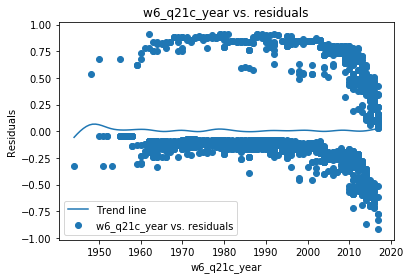

In [39]:
dependent_variable = list(X['w6_q21c_year'])

plt.xlabel("w6_q21c_year")
plt.ylabel("Residuals")
plt.title("w6_q21c_year vs. residuals")
plt.scatter(dependent_variable, residuals, label = "w6_q21c_year vs. residuals")
trend_x, trend_y = get_trend_line(dependent_variable, residuals)
plt.plot(trend_x, trend_y, label="Trend line")
plt.legend()
plt.show()

Podobnie jak powyżej mamy dwie grupy punktów odpowiadające obu klasom. <br />
Linia trendu nie pokrywa się idealnie z prostą $y=0$, ale jest do niej bardzo zbliżona.

## Wartości Cooka

In [71]:
from sklearn.ensemble import RandomForestClassifier

def get_cook_value(model_class, X, y, row_id, mse, fitted_values):
    X_train = X.copy()
    X_train.drop(X.index[row_id])
    y.drop(y.index[row_id])
    model = model_class()
    model.fit(X_train, y)
    
    return mean_squared_error(fitted_values, model.predict_proba(X)[:, 1])/(len(X.columns)*mse)

def cook_values(model_class, X, y):
    model = model_class()
    model.fit(X, y)
    fitted_values = model.predict_proba(X)[:, 1]
    original_mse = mean_squared_error(y, fitted_values)
    
    values = []
    for i in range(0, len(X)):
        values.append(get_cook_value(model_class, X.copy(), y.copy(), i, original_mse, fitted_values))
        
    return values

values = cook_values(RandomForestClassifier, X[:100], y[:100])

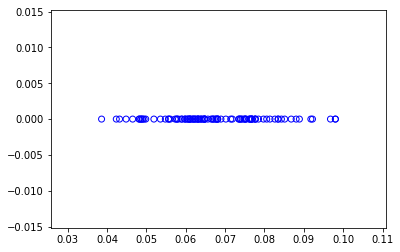

In [72]:
plt.scatter(values, np.zeros(len(values)), facecolors='none', edgecolors='b')
plt.show()

Wartości Cooka policzyłem dla 100 obserwacji, ponieważ dla wszystich wykres był nieczytelny. <br />
W danych nie widać wyraźnych obserwacji odstających.